In [2]:
import pandas as pd
# from graph_part import train_test_validation_split, stratified_k_fold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, matthews_corrcoef, log_loss, mean_squared_error, balanced_accuracy_score
from math import sqrt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import networkx as nx
from networkx.algorithms import community
import random
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    f1_score, log_loss, mean_squared_error, accuracy_score,
    balanced_accuracy_score, classification_report
)
def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient and other metrics.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = len([x for x in y_true if x == 1])
    N = len([x for x in y_true if x == 0])

    Tp, Fp = 0, 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1: Tp += 1
        elif y_true[i] == 0 and y_pred[i] == 1: Fp += 1

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt(
            (Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return (mcc, f" \n \
    P: {P:_} \n \
    Tp: {Tp:_} \n \
    Fp: {Fp:_} \n \
    N: {N:_} \n \
    Tn: {Tn:_} \n \
    Fn: {Fn:_}")


In [2]:
df_inphared = pd.read_csv("../data/processed/model_data.csv")
df_inphared = df_inphared[["Accession", "staining"]]
df_inphared.rename(columns={'Accession': 'id'}, inplace=True)
df_inphared

,id,staining
0,MN335248,negative
1,MK250029,negative
2,MK250028,negative
3,MK250027,negative
4,MK250026,negative
...,...,...
11151,EF380009,negative
11152,DQ490056,positive
11153,AJ414696,negative
11154,AJ344259,negative


In [6]:
df = pd.read_csv("../data/processed/pharokka/engineered_features.csv")
df = pd.merge(df_inphared, df, left_on='id', right_on='id', how='left')
df = df[['id', 'staining', 'genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared',
       'positive_strand_%_inphared', 'negative_strand_%_inphared',
       'coding_capacity_inphared', 'molecule_type_inphared_DNA',
       'topology_inphared_linear', 'jumbophage_inphared',
       'topology_linear_inphared', 'topology_circular_inphared',
       'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_DNA',
       'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA',
       #'contig_x', 'contig_y', 'contig', 'sequence_inphared',
       'length', 'gc_perc', 'transl_table', 'cds_coding_density',
       'CARD_AMR_Genes', 'CDS', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'index', 'frame_positive',
       'frame_negative']]
# assigning staining based on model
print(df.shape)
df.head()

NameError: name 'df_inphared' is not defined

In [126]:
df["CRISPRs"].value_counts()

CRISPRs
0.0    11130
1.0       22
2.0        3
3.0        1
Name: count, dtype: int64

In [51]:
df['staining'].value_counts()

staining
negative    7932
positive    3224
Name: count, dtype: int64

Checking why df and df2 are different

In [58]:
df2 = pd.read_csv("../data/processed/model_data2.csv", index_col=0)

print(df2.shape)
df2.head()
print(df2.columns)

(11154, 17)
Index(['id', 'genome_length', 'gc_%', 'sequence', 'reverse_complement',
       'cds_number', 'positive_strand_%', 'negative_strand_%',
       'coding_capacity', 'trna_count', 'molecule_type_DNA',
       'molecule_type_RNA', 'molecule_type_ss-DNA', 'molecule_type_ss-RNA',
       'jumbophage', 'topology_circular', 'topology_linear'],
      dtype='object')


In [5]:
not_in_df = df[~df['Accession'].isin(df2['id'])]
not_in_df

,Accession,staining,Genome Length (bp),Jumbophage,molGC (%),Number CDS,Positive Strand (%),Negative Strand (%),Coding Capacity (%),tRNAs,Molecule_DNA,Molecule_RNA,Molecule_ss-DNA,Molecule_ss-RNA
11080,MPU46938,positive,15664,False,69.344,25,100.000000,0.000000,91.183606,0,True,False,False,False
11122,L67CG,positive,22195,False,35.990,39,53.846154,46.153846,92.507321,0,True,False,False,False
11126,BL5GENM,positive,2435,False,33.265,4,100.000000,0.000000,51.252567,0,True,False,False,False


### Homology partitioning (Graph-Part)

In [6]:
'''sequences = pd.read_csv('../data/interim/feature_engineering/feature_engineering_genomes.csv')
sequences = sequences[['id', 'sequence']]
df.reset_index()
df = df.merge(sequences, left_on='Accession', right_on = 'id', how='left')
df.head()

sequences = df['sequence'].to_numpy()
labels = df['staining'].to_numpy()
# priority = df['experimental'].to_numpy()
train_idx, test_idx, valid_idx = train_test_validation_split(sequences, 
                                                             labels=labels,  
                                                             alignment_mode='mmseqs2', 
                                                             threads = 2,
                                                             threshold = 0.3,
                                                             test_size = 0.15,
                                                             valid_size = 0.05
                                                            )'''

"sequences = pd.read_csv('../data/interim/feature_engineering/feature_engineering_genomes.csv')\nsequences = sequences[['id', 'sequence']]\ndf.reset_index()\ndf = df.merge(sequences, left_on='Accession', right_on = 'id', how='left')\ndf.head()\n\nsequences = df['sequence'].to_numpy()\nlabels = df['staining'].to_numpy()\n# priority = df['experimental'].to_numpy()\ntrain_idx, test_idx, valid_idx = train_test_validation_split(sequences, \n                                                             labels=labels,  \n                                                             alignment_mode='mmseqs2', \n                                                             threads = 2,\n                                                             threshold = 0.3,\n                                                             test_size = 0.15,\n                                                             valid_size = 0.05\n                                                            )"

### Homology partitioning (mmseq)

In [7]:
'''column_names = ["Cluster", "Sequences"]

df = pd.read_csv("../data/interim/clustering/clusterRes_cluster.tsv", sep="\t", header=None, names=column_names)
grouped = df.groupby('Cluster')['Sequences'].agg(list).reset_index()
grouped'''

'column_names = ["Cluster", "Sequences"]\n\ndf = pd.read_csv("../data/interim/clustering/clusterRes_cluster.tsv", sep="\t", header=None, names=column_names)\ngrouped = df.groupby(\'Cluster\')[\'Sequences\'].agg(list).reset_index()\ngrouped'

### Traditional trainining and testing split

In [8]:
'''# Features (independent variables)
features = ['Genome Length (bp)', 'Jumbophage', 'molGC (%)', 'Number CDS',
            'Positive Strand (%)', 'Negative Strand (%)', 'Coding Capacity (%)',
            'tRNAs', 'Molecule_DNA', 'Molecule_RNA', 'Molecule_ss-DNA', 'Molecule_ss-RNA']

features = ['genome_length', 'jumbophage', 'gc_%',
       'trna_count', 'cds_number', 'coding_capacity', 'positive_strand_%',
       'negative_strand_%', 'molecule_type_ss-DNA', 'molecule_type_DNA',
       'molecule_type_RNA', 'molecule_type_ss-RNA', 'topology_circular','topology_linear']
# Target variable (dependent variable)
target = 'staining'

# Extract features and target
X = df[features]
y = df[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)'''

"# Features (independent variables)\nfeatures = ['Genome Length (bp)', 'Jumbophage', 'molGC (%)', 'Number CDS',\n            'Positive Strand (%)', 'Negative Strand (%)', 'Coding Capacity (%)',\n            'tRNAs', 'Molecule_DNA', 'Molecule_RNA', 'Molecule_ss-DNA', 'Molecule_ss-RNA']\n\nfeatures = ['genome_length', 'jumbophage', 'gc_%',\n       'trna_count', 'cds_number', 'coding_capacity', 'positive_strand_%',\n       'negative_strand_%', 'molecule_type_ss-DNA', 'molecule_type_DNA',\n       'molecule_type_RNA', 'molecule_type_ss-RNA', 'topology_circular','topology_linear']\n# Target variable (dependent variable)\ntarget = 'staining'\n\n# Extract features and target\nX = df[features]\ny = df[target]\n\n# Split the data into training and testing sets (80% train, 20% test)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)"

# Homology Partitioning with from MASH and NetworkX output

I will load the mash distances and use them to separate the DNA into communities. Two nodes will be used for validation: 934 (negative) and 469 (positive). These two nodes are taken from the NetworkX graph. The rest of the data will be used to train the model

In [52]:
# Assuming 'distances_df' is your DataFrame containing the distance and identity information
distances_df = pd.read_csv('../data/interim/clustering/mash_distances.csv')  # Load your CSV file

# Create a new graph
G = nx.Graph()

# Add edges to the graph
for index, row in distances_df.iterrows():
    # Inverse the identity value to use it as 'distance' if needed
    # Or you can directly use the identity value depending on how you want to cluster
    distance = 1 - row['Identity'] / 100  # Convert percentage to a float value between 0 and 1
    G.add_edge(row['Genome1'], row['Genome2'], weight=distance)

# Now G contains your graph with weighted edges based on sequence identity
# You can now use various clustering or community detection algorithms provided by NetworkX

# For example, to get clusters using the greedy modularity community detection algorithm:

communities = community.greedy_modularity_communities(G, weight='weight')
# This will return a list of sets, where each set is a community of nodes (sequences)

print(len(communities))
# To see the communities:
counter = 0
for i, community_set in enumerate(communities, start=1):
    print(f"Community {i}: {community_set}")
    counter += 1
    if counter == 5:
        break

1116
Community 1: frozenset({'MK250022', 'MK250023', 'MN335248', 'MK250027', 'MK250026', 'MK250025', 'MK250021', 'MK250029', 'MK250024', 'MK250028'})
Community 2: frozenset({'MK250016', 'MK250018', 'MK250019', 'MG592427', 'MG592615', 'MK250020', 'MK250015', 'MK250017', 'MG592455', 'MG592402'})
Community 3: frozenset({'OR204650', 'OR204652', 'HM208303', 'OR413347', 'OR204649', 'AF334111', 'OR204651', 'HM066936', 'MG592394', 'OR413345'})
Community 4: frozenset({'OR413342', 'MZ892903', 'OQ745667', 'AY129330', 'OQ451773', 'OR413344', 'OR290970', 'ON212266', 'ON470617', 'MN923124'})
Community 5: frozenset({'AY129332', 'EU826469', 'KY385384', 'KY385381', 'JX262223', 'JX262221', 'JX262225', 'JX262224', 'AY129336', 'JX262222'})


In [8]:
# Let's assume 'communities' is the list of frozensets you received from the output of the community detection algorithm
# Initialize the separate variables for storing removed communities
removed_communities = []

# Community numbers to remove (1-indexed as per your enumeration, so subtract 1 for 0-indexed Python lists)
communities_to_remove = [934 - 1, 469 - 1]  # -1 because lists are 0-indexed in Python

# Sort the list in reverse so removing by index doesn't affect the order of unvisited items
for community_index in sorted(communities_to_remove, reverse=True):
    # Remove the community and store it in the 'removed_communities' list if it exists
    try:
        removed_communities.append(communities.pop(community_index)) # pop method removes by index
    except IndexError as e:
        print(f"No community at index: {community_index + 1}")  # Add 1 to match your enumeration

# At this point, 'communities' variable has communities 934 and 469 removed
# 'removed_communities' contains the removed communities

# To verify the result, you can print the remaining and removed communities
#  print("Remaining communities:")
# for i, community_set in enumerate(communities, start=1):
#     print(f"Community {i}: {community_set}")

print("\nRemoved communities:")
for i, community_set in enumerate(removed_communities, start=1):
    print(f"Removed Community {i}: {community_set}")


Removed communities:
Removed Community 1: frozenset({'KX349302', 'KX349300', 'KX349297', 'KX349305', 'KX349303', 'KX349306', 'KX349299', 'KX349304', 'KX349298', 'KX349301'})
Removed Community 2: frozenset({'MN871503', 'MN871498', 'MN871495', 'MN871502', 'MN871497', 'MN871496', 'MN871501', 'MN871494', 'MN871499', 'MN871500'})


Making sure the communities were removed

In [9]:
# Function to find to which community (index) a given entry belongs
def find_community(entry, communities_list):
    for index, community in enumerate(communities_list):
        if entry in community:
            return f"Community {index + 1}"  # +1 because index in Python starts at 0
    return "Entry not found in any community"


# Example usage:
entry = 'KX349302' # Replace this with any entry you're searching for
community2 = find_community(entry, communities)
print(f"The entry {entry} belongs to {community2}")


The entry KX349302 belongs to Entry not found in any community


In [10]:
# Community to find the index of
community_to_find = frozenset({'MN871494', 'MN871501', 'MN871498', 'MN871495', 'MN871497', 'MN871503', 'MN871496', 'MN871500', 'MN871499', 'MN871502'})

# Find the index of the community
community_index = next((index for index, community in enumerate(communities) if community == community_to_find), -1)

community_index

-1

# Obtain training and testing data based on communities

In [11]:
df.head()

,id,staining,genome_length_inphared,gc_%_inphared,cds_number_inphared,positive_strand_%_inphared,negative_strand_%_inphared,coding_capacity_inphared,molecule_type_inphared_DNA,topology_inphared_linear,...,nucleotide_metabolism,other,tRNAs,tail,tmRNAs,transcription,unkown_function,index,frame_positive,frame_negative
0,MN335248,negative,7045.0,60.298,13.0,84.62,15.38,88.828957,True,True,...,0.0,1.0,0.0,1.0,0.0,0.0,9.0,0.0,11.0,2.0
1,MK250029,negative,540217.0,25.796,828.0,47.22,52.78,68.310512,True,True,...,51.0,22.0,28.0,5.0,0.0,2.0,726.0,0.0,391.0,437.0
2,MK250028,negative,550053.0,26.012,861.0,52.38,47.62,69.365679,True,True,...,48.0,25.0,30.0,6.0,0.0,2.0,758.0,0.0,451.0,410.0
3,MK250027,negative,551627.0,26.022,862.0,53.13,46.87,69.465236,True,True,...,51.0,24.0,33.0,6.0,0.0,2.0,759.0,0.0,458.0,404.0
4,MK250026,negative,550702.0,26.020,861.0,53.31,46.69,69.513276,True,True,...,50.0,25.0,33.0,6.0,0.0,2.0,757.0,0.0,459.0,402.0


In [53]:
# Create a mapping dictionary from accession code to community index
accession_to_community = {}
for i, community in enumerate(communities):
    for accession in community:
        accession_to_community[accession] = i

# Map the 'Accession' column to a new 'Community' column
df['Community'] = df['id'].map(accession_to_community)
# df[['Accession','Community']].head()

# Now, decide how to split the communities into train and test sets
# For simplicity, let's say you want 80% of communities in the training set
# First, let's decide which community indices will go into training

# Set the random seed for reproducibility
random.seed(42)

# Shuffle the community indices to randomly select 80% for training
community_indices = list(range(len(communities)))
random.shuffle(community_indices)
train_community_count = int(0.8 * len(community_indices))
train_community_indices = community_indices[:train_community_count]
test_community_indices = community_indices[train_community_count:]

# Now, we can split the dataframe based on these indices
train_df = df[df['Community'].isin(train_community_indices)]
test_df = df[df['Community'].isin(test_community_indices)]

# The 'train_df' dataframe contains the training set, and 'test_df' contains the test set


### Checking the split
# Collect community indices in the training and test set
train_communities = set(train_df['Community'].unique())
test_communities = set(test_df['Community'].unique())

# Check for intersection
common_communities = train_communities.intersection(test_communities)

# If the intersection is empty, then the split is correct; otherwise, there's an issue
if common_communities:
    print(f"Error: Communities with indices {common_communities} appear in both training and test sets.")
else:
    print("Success: All communities are exclusively in either the training or the test set.")

Success: All communities are exclusively in either the training or the test set.


In [54]:
# Set 'Accession' as the index for both train_df and test_df
train_df = train_df.set_index('id')
test_df = test_df.set_index('id')

# Drop the 'Community' column from both dataframes
train_df = train_df.drop(columns='Community')
test_df = test_df.drop(columns='Community')


In [55]:
print(train_df['staining'].value_counts())
print(test_df['staining'].value_counts())

staining
negative    6320
positive    2593
Name: count, dtype: int64
staining
negative    1612
positive     628
Name: count, dtype: int64


In [15]:
train_df.columns

Index(['staining', 'genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'molecule_type_inphared_DNA', 'topology_inphared_linear',
       'jumbophage_inphared', 'topology_linear_inphared',
       'topology_circular_inphared', 'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA', 'length', 'gc_perc', 'transl_table',
       'cds_coding_density', 'CARD_AMR_Genes', 'CDS', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'index', 'frame_positive',
       'frame_negative'],
      dtype='object')

In [56]:

features = ['Genome Length (bp)', 'Jumbophage', 'molGC (%)', 'Number CDS',
            'Positive Strand (%)', 'Negative Strand (%)', 'Coding Capacity (%)',
            'tRNAs', 'Molecule_DNA', 'Molecule_RNA', 'Molecule_ss-DNA', 'Molecule_ss-RNA']

# features = ['genome_length', 'jumbophage', 'gc_%',
#        'trna_count', 'cds_number', 'coding_capacity', 'positive_strand_%',
#        'negative_strand_%', 'molecule_type_ss-DNA', 'molecule_type_DNA',
#        'molecule_type_RNA', 'molecule_type_ss-RNA', 'topology_circular','topology_linear']
# Target variable (dependent variable)

features = ['genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'molecule_type_inphared_DNA', 'topology_inphared_linear',
       'jumbophage_inphared', 'topology_linear_inphared',
       'topology_circular_inphared', 'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA', 'length', 'gc_perc', 'transl_table',
       'cds_coding_density', 'CARD_AMR_Genes', 'CDS', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'index', 'frame_positive',
       'frame_negative']

target = 'staining'

# Extract features and target
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Logistic regression model

In [57]:
# Train a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/alvaroguleon/miniconda3/envs/phage/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [58]:
# Predict probabilities on the test set
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Predict class labels for F1 score calculation
y_pred = logreg.predict(X_test)

# Encode labels for mean squared error calculation
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)


In [59]:
# Calculate F1 score
positive_label = 'positive'
f1score = f1_score(y_test, y_pred, pos_label=positive_label)

# Calculate log loss using predicted probabilities
logloss = log_loss(y_test, y_pred_proba)

# Calculate mean squared error using encoded labels
mse = mean_squared_error(y_test_encoded, y_pred_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_encoded)

# Calculate Matthews Correlation Coefficient (MCC)
mcc, mcc_details = matthews(y_test_encoded, y_pred_encoded)

# Generate the classification report
classification_report_str = classification_report(y_test_encoded, y_pred_encoded)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Balanced Accuracy:', balanced_accuracy)
print('Log Loss:', logloss)  # Use the calculated log loss
print('Mean Squared Error:', mse)
print()
print('F1 Score:', f1score)
print('Matthews Correlation Coefficient:', mcc)
print('Matthews Correlation Coefficient Details:', mcc_details)
print()
print('Classification Report:\n', classification_report_str)


Accuracy: 0.7642857142857142
Balanced Accuracy: 0.609750122488976
Log Loss: 0.5440726201163174
Mean Squared Error: 0.2357142857142857

F1 Score: 0.38028169014084506
Matthews Correlation Coefficient: 0.3286457926897027
Matthews Correlation Coefficient Details:  
     P: 628 
     Tp: 162 
     Fp: 62 
     N: 1_612 
     Tn: 1_550 
     Fn: 466

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.85      1612
           1       0.72      0.26      0.38       628

    accuracy                           0.76      2240
   macro avg       0.75      0.61      0.62      2240
weighted avg       0.76      0.76      0.72      2240



# Random Forest

In [60]:
# Train a logistic regression model
logreg = RandomForestClassifier()
logreg.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Predict probabilities on the test set
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Predict class labels for F1 score calculation
y_pred = logreg.predict(X_test)

# Encode labels for mean squared error calculation
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

In [62]:
# Calculate F1 score
positive_label = 'positive'
f1score = f1_score(y_test, y_pred, pos_label=positive_label)

# Calculate log loss using predicted probabilities
logloss = log_loss(y_test, y_pred_proba)

# Calculate mean squared error using encoded labels
mse = mean_squared_error(y_test_encoded, y_pred_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_encoded)

# Calculate Matthews Correlation Coefficient (MCC)
mcc, mcc_details = matthews(y_test_encoded, y_pred_encoded)

# Generate the classification report
classification_report_str = classification_report(y_test_encoded, y_pred_encoded)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Balanced Accuracy:', balanced_accuracy)
print('Log Loss:', logloss)  # Use the calculated log loss
print('Mean Squared Error:', mse)
print()
print('F1 Score:', f1score)
print('Matthews Correlation Coefficient:', mcc)
print('Matthews Correlation Coefficient Details:', mcc_details)
print()
print('Classification Report:\n', classification_report_str)

Accuracy: 0.9647321428571428
Balanced Accuracy: 0.9473080084082754
Log Loss: 0.13619854858207464
Mean Squared Error: 0.03526785714285714

F1 Score: 0.9351927809680066
Matthews Correlation Coefficient: 0.9117902453694315
Matthews Correlation Coefficient Details:  
     P: 628 
     Tp: 570 
     Fp: 21 
     N: 1_612 
     Tn: 1_591 
     Fn: 58

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1612
           1       0.96      0.91      0.94       628

    accuracy                           0.96      2240
   macro avg       0.96      0.95      0.96      2240
weighted avg       0.96      0.96      0.96      2240



# Random forest with weights

In [27]:
# Features (independent variables)
features = ['genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'molecule_type_inphared_DNA', 'topology_inphared_linear',
       'jumbophage_inphared', 'topology_linear_inphared',
       'topology_circular_inphared', 'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA', 'length', 'gc_perc', 'transl_table',
       'cds_coding_density', 'CARD_AMR_Genes', 'CDS', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'index', 'frame_positive',
       'frame_negative']
# Target variable (dependent variable)
target = 'staining'
X = df[features]
y = df[target]

# Ensure y only contains valid labels ('negative' and 'positive')
y = y[(y == 'negative') | (y == 'positive')]

# Encode the target variable 'staining' to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Train a random forest model with class weighting
logreg = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})
logreg.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Predict class labels for F1 score calculation
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
f1score = f1_score(y_test, y_pred, pos_label=1)  # Positive class is 1 after encoding
logloss = log_loss(y_test, y_pred_proba)
mse = mean_squared_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Generate the classification report
classification_report_str = classification_report(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Balanced Accuracy:', balanced_accuracy)
print('Log Loss:', logloss)  # Use the calculated log loss
print('Mean Squared Error:', mse)
print()
print('F1 Score:', f1score)
print('Matthews Correlation Coefficient:', mcc)
print('Matthews Correlation Coefficient Details:', mcc_details)
print()
print('Classification Report:\n', classification_report_str)

Accuracy: 0.9623655913978495
Balanced Accuracy: 0.9399387246676643
Log Loss: 0.10605187230672607
Mean Squared Error: 0.03763440860215054

F1 Score: 0.9305785123966942
Matthews Correlation Coefficient: 0.9274281197271307
Matthews Correlation Coefficient Details:  
     P: 628 
     Tp: 580 
     Fp: 17 
     N: 1_602 
     Tn: 1_585 
     Fn: 48

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1598
           1       0.98      0.89      0.93       634

    accuracy                           0.96      2232
   macro avg       0.97      0.94      0.95      2232
weighted avg       0.96      0.96      0.96      2232



# Validation on removed communities

In [30]:
df[["id", "staining"]].head()

,id,staining
0,MN335248,negative
1,MK250029,negative
2,MK250028,negative
3,MK250027,negative
4,MK250026,negative


In [41]:
# Flatten the removed_communities frozensets into a list
removed_accessions = [item for community in removed_communities for item in community]

# Filter the original dataframe to get the validation set based on Accession being in removed_accessions
validation_df = df[df['id'].isin(removed_accessions)].copy().set_index('id')

# Prepare features and true labels from the validation set
X_validation = validation_df[features]
y_validation_true = validation_df[target]

# Encode 'staining' labels to numerical values using the same encoder used during training
y_validation_encoded = label_encoder.transform(y_validation_true)

# Predict the staining for the validation set and get probabilities for both classes
y_validation_pred_proba = logreg.predict_proba(X_validation)

# Predict the staining for the validation set (numerical labels)
y_validation_pred_numerical = logreg.predict(X_validation)

# Convert the numerical predictions back to string labels
y_validation_pred = label_encoder.inverse_transform(y_validation_pred_numerical)

# Since y_validation_pred contains strings, we don't need to inverse_transform it again
validation_df['Predicted Staining'] = y_validation_pred  # Direct assignment

# Now validation_df will have the predicted staining, add probability columns based on predict_proba output
validation_df['Probability Negative'] = y_validation_pred_proba[:, 0]  # Probability of 'negative'
validation_df['Probability Positive'] = y_validation_pred_proba[:, 1]  # Probability of 'positive'

# Find the entries that the model predicted incorrectly
incorrect_predictions = validation_df[validation_df[target] != validation_df['Predicted Staining']]

# Evaluate the model on the validation set using the same metrics as before
f1score_validation = f1_score(y_validation_encoded, label_encoder.transform(y_validation_pred), pos_label=label_encoder.transform([positive_label])[0])
logloss_validation = log_loss(y_validation_encoded, y_validation_pred_proba)
mse_validation = mean_squared_error(y_validation_encoded, label_encoder.transform(y_validation_pred))
accuracy_validation = accuracy_score(y_validation_encoded, label_encoder.transform(y_validation_pred))
balanced_accuracy_validation = balanced_accuracy_score(y_validation_encoded, label_encoder.transform(y_validation_pred))
classification_report_validation = classification_report(y_validation_encoded, label_encoder.transform(y_validation_pred))

# Print the evaluation metrics for the validation set
print('Validation Accuracy:', accuracy_validation)
print('Validation Balanced Accuracy:', balanced_accuracy_validation)
print('Validation Log Loss:', logloss_validation)
print('Validation Mean Squared Error:', mse_validation)
print()
print('Validation F1 Score:', f1score_validation)
print()
print('Validation Classification Report:\n', classification_report_validation)

# Print the incorrect predictions for review
if incorrect_predictions.empty:
    incorrect_pred_str = "There were no incorrect predictions\n"
else:
    # If it's not empty, convert the DataFrame to a string for the report
    incorrect_pred_str = f"Incorrect Predictions:\n{incorrect_predictions}\n"

# Print the incorrect predictions message
print(incorrect_pred_str)


Validation Accuracy: 0.95
Validation Balanced Accuracy: 0.95
Validation Log Loss: 0.09370147925065068
Validation Mean Squared Error: 0.05

Validation F1 Score: 0.9473684210526316

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

Incorrect Predictions:
          staining  genome_length_inphared  gc_%_inphared  \
id                                                          
MN871503  positive                 40176.0         45.841   

          cds_number_inphared  positive_strand_%_inphared  \
id                                                          
MN871503                 64.0                       57.81   

          negative_strand_%_inphared  coding_capacity_inphared  \
i

In [77]:
validation_df

,staining,Genome Length (bp),Jumbophage,molGC (%),Number CDS,Positive Strand (%),Negative Strand (%),Coding Capacity (%),tRNAs,Molecule_DNA,Molecule_RNA,Molecule_ss-DNA,Molecule_ss-RNA,Community,Probability Negative,Probability Positive,Predicted Staining
Accession,,,,,,,,,,,,,,,,,
MN871444,negative,269351,True,45.892,333,89.189189,10.810811,94.311140,0,True,False,False,False,NaN,0.96,0.04,negative
MN871443,positive,58036,False,39.849,96,86.458333,13.541667,87.967813,1,True,False,False,False,NaN,0.01,0.99,positive
MN871442,negative,223245,True,38.527,393,14.503817,85.496183,93.604784,8,True,False,False,False,NaN,0.97,0.03,negative
MN871441,negative,228419,True,37.810,430,14.186047,85.813953,90.586160,10,True,False,False,False,NaN,0.99,0.01,negative
MN871440,negative,221312,True,41.954,326,85.889571,14.110429,93.305379,22,True,False,False,False,NaN,0.99,0.01,negative
OM913599,negative,45276,False,47.400,66,100.000000,0.000000,91.459051,0,True,False,False,False,NaN,0.86,0.14,negative
OM913598,negative,43136,False,52.587,55,98.181818,1.818182,92.477281,0,True,False,False,False,NaN,0.98,0.02,negative
OM913597,negative,42433,False,52.688,54,100.000000,0.000000,92.277237,0,True,False,False,False,NaN,1.00,0.00,negative
OM810291,negative,57429,False,52.503,69,100.000000,0.000000,88.885406,2,True,False,False,False,NaN,0.97,0.03,negative


# Feature selection

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

model = RandomForestClassifier()
sfm = SelectFromModel(model, threshold='mean')
fit = sfm.fit(X_train, y_train)
selected_features_sfm = X_train.columns[fit.get_support()]


In [46]:
selected_features_sfm

Index(['genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
       'positive_strand_%_inphared', 'negative_strand_%_inphared',
       'coding_capacity_inphared', 'length', 'gc_perc', 'cds_coding_density',
       'CDS', 'connector', 'head_packaging', 'lysis', 'nucleotide_metabolism',
       'tail', 'transcription', 'unkown_function', 'frame_positive',
       'frame_negative'],
      dtype='object')

# Cross validation

In [68]:
import time
# Create a mapping dictionary from accession code to community index
accession_to_community = {}
for i, community in enumerate(communities):
    for accession in community:
        accession_to_community[accession] = i

# Map the 'Accession' column to a new 'Community' column
df['Community'] = df['id'].map(accession_to_community)
# df[['Accession','Community']].head()

# Now, decide how to split the communities into train and test sets
# For simplicity, let's say you want 80% of communities in the training set
# First, let's decide which community indices will go into training

# Set the random seed for reproducibility
np.random.seed(int(time.time()))


# Shuffle the community indices to randomly select 80% for training
community_indices = list(range(len(communities)))
random.shuffle(community_indices)

# Divide community indices into five groups
fold_size = len(community_indices) // 5
community_folds = [community_indices[i:i + fold_size] for i in range(0, len(community_indices), fold_size)]

def split_based_on_communities(df, train_communities, validation_communities):
    train_df = df[df['Community'].isin(train_communities)]
    validation_df = df[df['Community'].isin(validation_communities)]

    return train_df, validation_df

In [106]:
# Random forest with a small dataframe
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs = []  # True Positive Rates
fprs = []  # False Positive Rates
precisions = []
recalls = []
thresholds_pr = []
confusion_matrices = []

for fold in range(5):
    print(f"Processing fold {fold + 1}...")

    # Determine validation and training community indices for this fold
    validation_communities = community_folds[fold]
    training_communities = [index for i, fold_indices in enumerate(community_folds) if i != fold for index in fold_indices]

    # Split the dataframe
    train_fold_df, validation_fold_df = split_based_on_communities(df, training_communities, validation_communities)

    # # Initialize the StandardScaler
    # scaler = RobustScaler()
    # scaler = StandardScaler()
    # # Normalize the training data and fit the scaler
    # X_train_fold = scaler.fit_transform(train_fold_df[features])
    # y_train_fold = train_fold_df[target]

  # Prepare training and validation data
    X_train_fold = train_fold_df[features]
    y_train_fold = train_fold_df[target]
    X_validation_fold = validation_fold_df[features]
    y_validation_fold = validation_fold_df[target]

    # Train a RandomForestClassifier model (or any other model of your choice)
    rf = RandomForestClassifier()
    rf.fit(X_train_fold, y_train_fold)

    # Predict probabilities on the validation set
    y_pred_proba = rf.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = rf.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = 'positive'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs.append(tpr)
    fprs.append(fpr)

    # Precision-Recall Curve data
    precision, recall, thresholds = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions.append(precision)
    recalls.append(recall)
    thresholds_pr.append(thresholds)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    confusion_matrices.append(cm)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)
    
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values
})



metrics_df

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...


,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC
0,1,0.960864,0.940093,0.161139,0.039136,0.930344,0.905032
1,2,0.970404,0.955005,0.107881,0.029596,0.943686,0.924114
2,3,0.968161,0.953983,0.124073,0.031839,0.943336,0.921761
3,4,0.967265,0.952426,0.148285,0.032735,0.941647,0.919538
4,5,0.969058,0.955212,0.137032,0.030942,0.947925,0.926843


In [111]:
# Random forest with a bigger dataframe
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, f1_score, log_loss,
    mean_squared_error, accuracy_score,
    balanced_accuracy_score, classification_report,
    matthews_corrcoef
)
accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs = []  # True Positive Rates
fprs = []  # False Positive Rates
precisions = []
recalls = []
roc_auc_values = []
pr_auc_values = []
tp_values = []  # True Positives
fp_values = []  # False Positives
tn_values = []  # True Negatives
fn_values = []  # False Negatives

for fold in range(5):
    print(f"Processing fold {fold + 1}...")

    # Determine validation and training community indices for this fold
    validation_communities = community_folds[fold]
    training_communities = [index for i, fold_indices in enumerate(community_folds) if i != fold for index in fold_indices]

    # Split the dataframe
    train_fold_df, validation_fold_df = split_based_on_communities(df, training_communities, validation_communities)

    # # Initialize the StandardScaler
    # scaler = RobustScaler()
    # scaler = StandardScaler()
    # # Normalize the training data and fit the scaler
    # X_train_fold = scaler.fit_transform(train_fold_df[features])
    # y_train_fold = train_fold_df[target]

    # Prepare training and validation data
    X_train_fold = train_fold_df[features]
    y_train_fold = train_fold_df[target]
    X_validation_fold = validation_fold_df[features]
    y_validation_fold = validation_fold_df[target]

    # Train a RandomForestClassifier model
    rf = RandomForestClassifier()
    rf.fit(X_train_fold, y_train_fold)

    # Predict probabilities on the validation set
    y_pred_proba = rf.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = rf.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = 'positive'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs.append(tpr)
    fprs.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions.append(precision)
    recalls.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    tn, fp, fn, tp = cm.ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': tn_values})

metrics_df

Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...


,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC,ROC AUC,PR AUC,True Positives,False Positives,True Negatives,False Negatives
0,1,0.965362,0.946855,0.126135,0.034638,0.938645,0.916038,0.989211,0.980359,589,13,1557,1557
1,2,0.973094,0.958425,0.120689,0.026906,0.948805,0.931060,0.992536,0.982426,556,16,1614,1614
2,3,0.966368,0.950868,0.124142,0.033632,0.939952,0.917315,0.991947,0.985239,587,20,1568,1568
3,4,0.967265,0.950570,0.148698,0.032735,0.941271,0.919575,0.988234,0.981148,585,16,1572,1572
4,5,0.969507,0.956761,0.134171,0.030493,0.948872,0.927860,0.992622,0.988489,631,16,1531,1531


In [82]:
# Unscaled
metrics_df

,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC
0,1,0.964286,0.946026,0.121870,0.035714,0.934211,0.910665
1,2,0.964732,0.946822,0.148749,0.035268,0.935086,0.911792
2,3,0.965179,0.947618,0.122894,0.034821,0.935961,0.912919
3,4,0.963839,0.945230,0.121991,0.036161,0.933333,0.909538
4,5,0.965179,0.947132,0.166235,0.034821,0.935855,0.912924


In [96]:
# Standard scaled
metrics_df

,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC
0,1,0.962213,0.941495,0.126576,0.037787,0.932692,0.908400
1,2,0.970852,0.955838,0.108866,0.029148,0.944587,0.925277
2,3,0.967713,0.950885,0.121935,0.032287,0.942029,0.920701
3,4,0.968610,0.953370,0.148070,0.031390,0.943910,0.922882
4,5,0.969955,0.956267,0.134694,0.030045,0.949434,0.928991


In [99]:
# Robust scaled
metrics_df

,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC
0,1,0.960864,0.940093,0.126552,0.039136,0.930344,0.905032
1,2,0.972646,0.959698,0.108791,0.027354,0.948261,0.929950
2,3,0.972197,0.957281,0.120994,0.027803,0.950241,0.931809
3,4,0.969507,0.953536,0.147363,0.030493,0.945338,0.925143
4,5,0.969955,0.959129,0.133798,0.030045,0.949963,0.928893


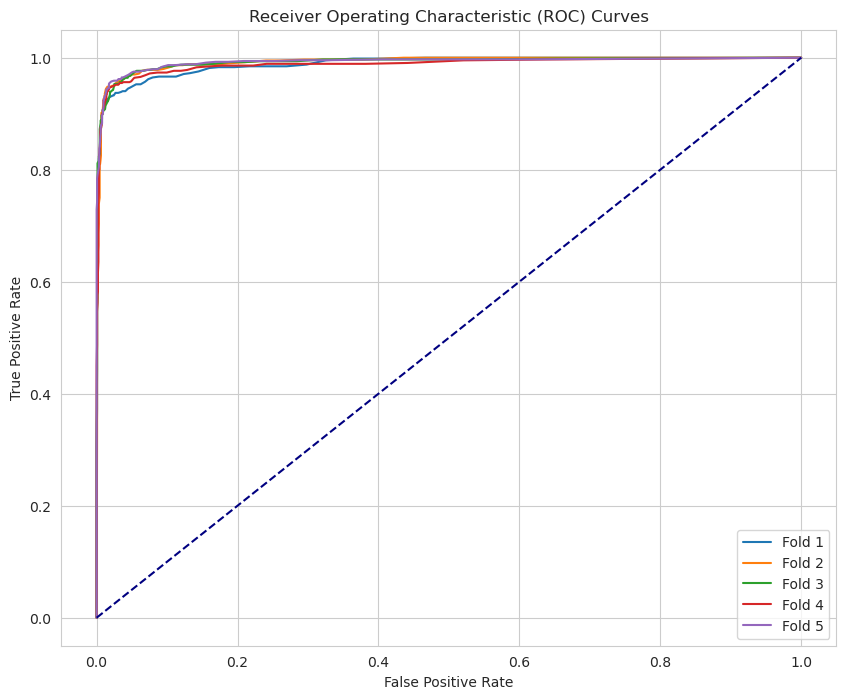

In [112]:
# Unscaled
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


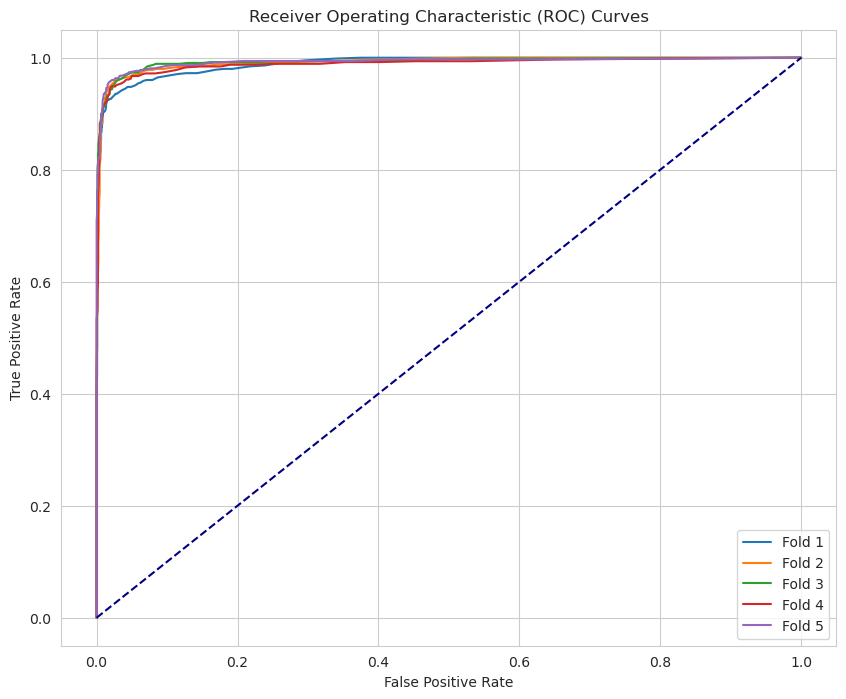

In [95]:
# Standard scaled
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


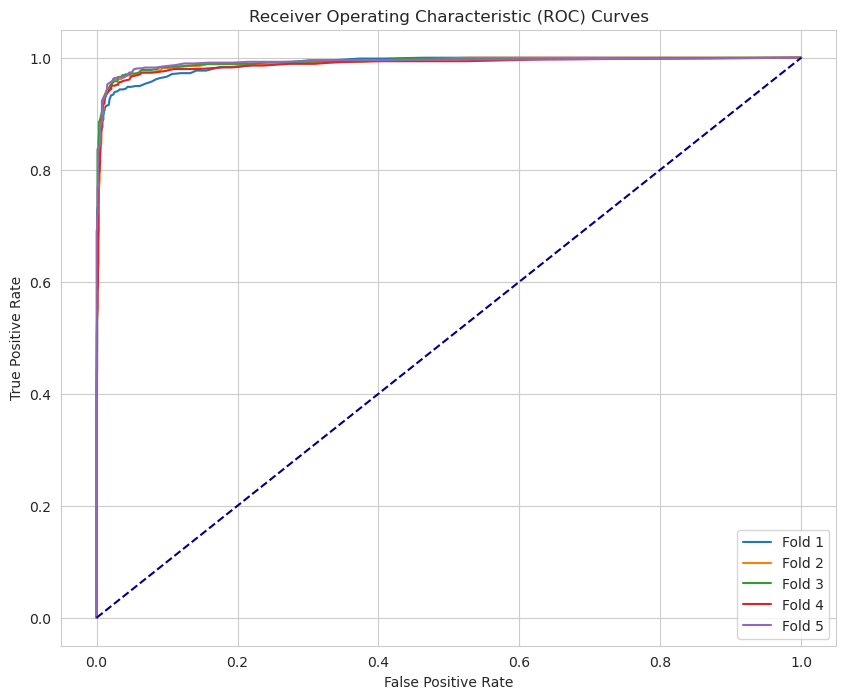

In [100]:
# Robust scaled
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


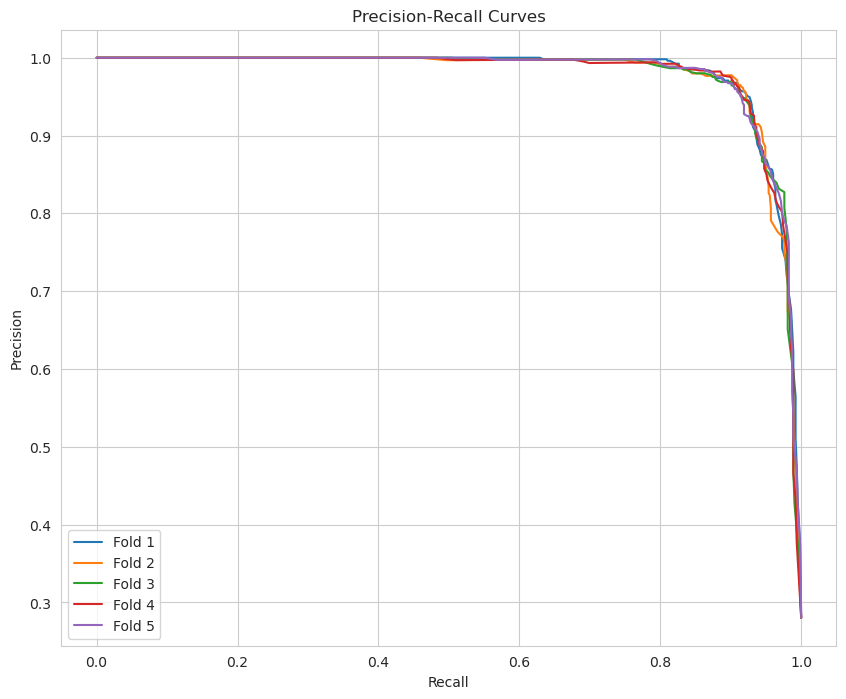

In [93]:
# Unscaled
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recalls[i], precisions[i], label=f'Fold {i+1}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


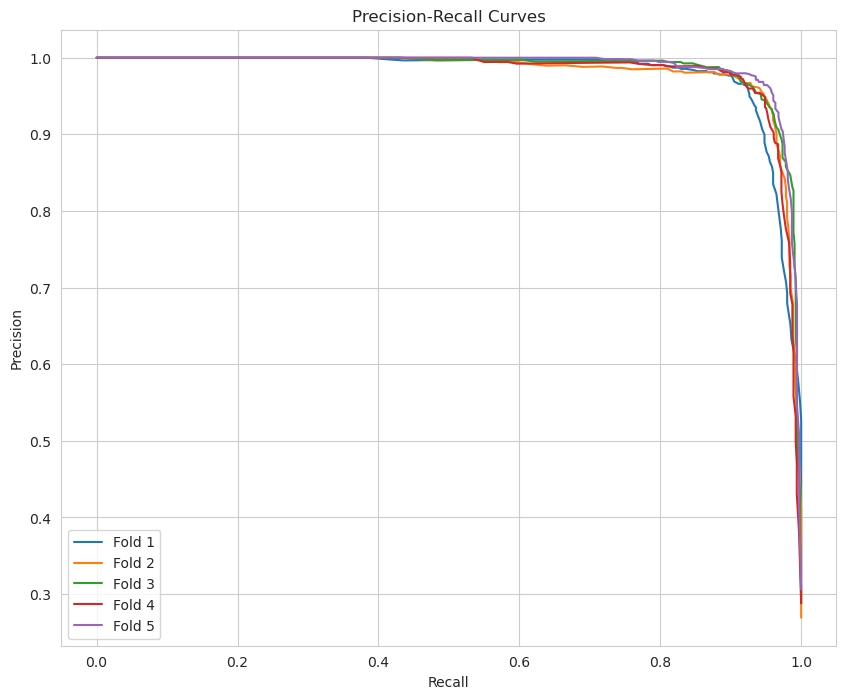

In [97]:
# Standard scaled
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recalls[i], precisions[i], label=f'Fold {i+1}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


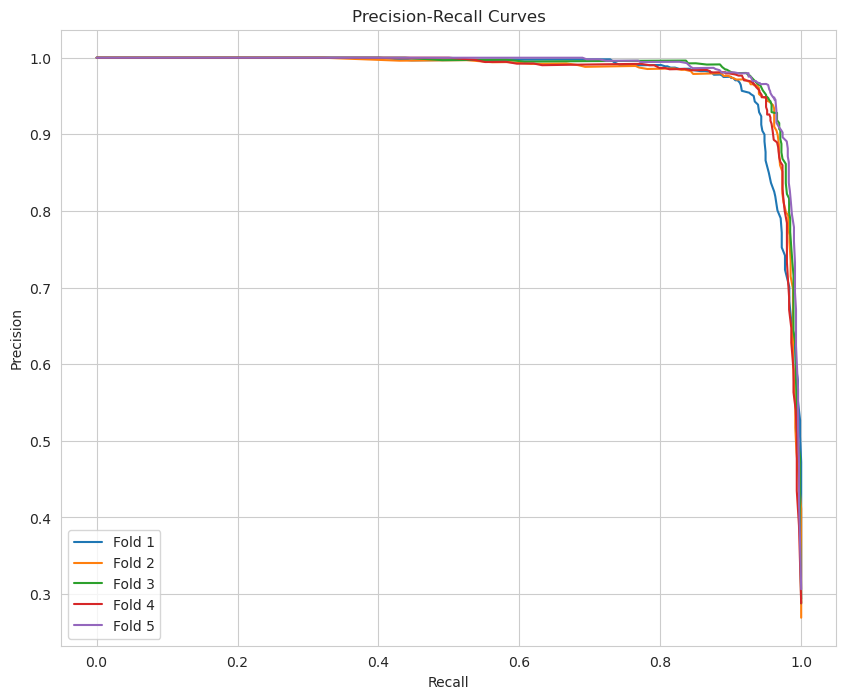

In [101]:
# Robust scaled
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recalls[i], precisions[i], label=f'Fold {i+1}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


/home/alvaroguleon/miniconda3/envs/phage/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alvaroguleon/miniconda3/envs/phage/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/alvaroguleon/miniconda3/envs/phage/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


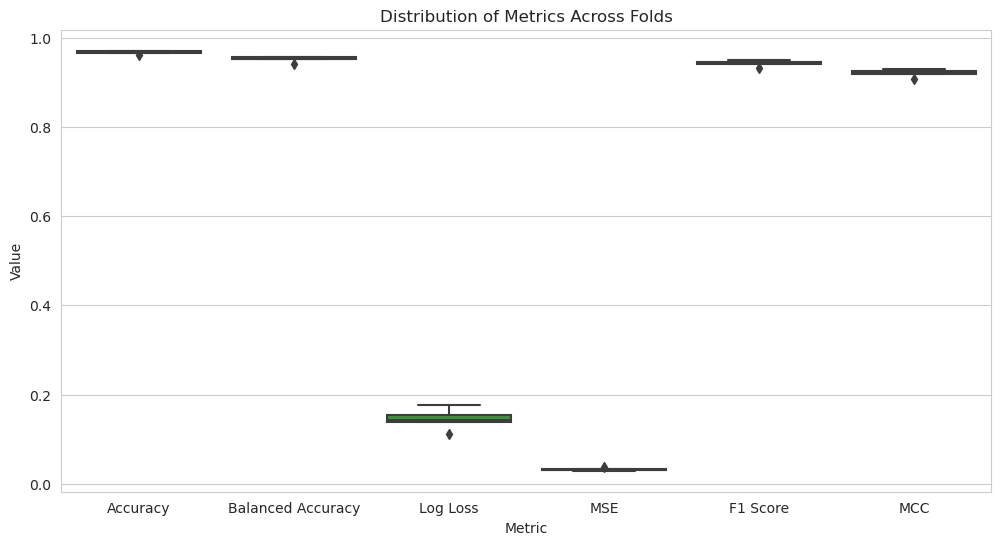

In [86]:
# Reshape the DataFrame for boxplot
melted_df = metrics_df.melt(id_vars='Fold', var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Metric', y='Value', data=melted_df)
plt.title('Distribution of Metrics Across Folds')
plt.show()
